# Crab Age Regression

## Define Problem:
This is a regression problem that's created as a [Kaggle competition](https://www.kaggle.com/competitions/playground-series-s3e16/overview). 

## Data to Use:
The dataset to use is supplied by the [Kaggle Playground Prediction Competition](https://www.kaggle.com/competitions/playground-series-s3e16/data).

In this data contains:
- test.csv
- train.csv

Both of these datasets were generated from a deep learning model, so this is synthetic data. 
The original Crab Age dataset (which isn't incorporated into the `train.csv` or `test.csv`) is [here](https://www.kaggle.com/datasets/sidhus/crab-age-prediction).

## Evaluation Metrics:
The submission will be evaluated using the Mean Absolute Error (MAE). 

The submission format should be in the following style:
> For each id in the test set, you must predict the target Age. The file should contain a header and have the following format:

    id,yield
    74051,10.2
    74051,3.6
    74051,11.9
    etc.


## Features to Use:

    sex: I, M, F (categorical)
    length: float
    diameter: float
    height: float
    weight: float
    shucked weight: float
    viscera weight: float
    shell weight: float
    age: int


## Import Libraries

In [2]:
import glob, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# preprocess
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# model
from sklearn import linear_model
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# evaluation
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Load Data

In [4]:
files = glob.glob("data/crab_age.zip")

for file in files:
    with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall('data/crab_age_raw')

In [3]:
# Load datasets
train_df = pd.read_csv("data/crab_age_raw/train.csv")
test_df = pd.read_csv("data/crab_age_raw/test.csv")

## EDA

In [4]:
print(train_df.head())
print(len(train_df))

   id Sex  Length  Diameter  Height     Weight  Shucked Weight   
0   0   I  1.5250    1.1750  0.3750  28.973189       12.728926  \
1   1   I  1.1000    0.8250  0.2750  10.418441        4.521745   
2   2   M  1.3875    1.1125  0.3750  24.777463       11.339800   
3   3   F  1.7000    1.4125  0.5000  50.660556       20.354941   
4   4   I  1.2500    1.0125  0.3375  23.289114       11.977664   

   Viscera Weight  Shell Weight  Age  
0        6.647958      8.348928    9  
1        2.324659      3.401940    8  
2        5.556502      6.662133    9  
3       10.991839     14.996885   11  
4        4.507570      5.953395    8  
74051


These seem to be the following feature attributes:
- sex: I, M, F (categorical)
- length: float 
- diameter: float
- height: float
- weight: float
- shucked weight: float
- viscera weight: float
- shell weight: float
- age: int 

### Missing Values Analysis

In [5]:
train_df.isna().sum()

id                0
Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
Age               0
dtype: int64

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74051 entries, 0 to 74050
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              74051 non-null  int64  
 1   Sex             74051 non-null  object 
 2   Length          74051 non-null  float64
 3   Diameter        74051 non-null  float64
 4   Height          74051 non-null  float64
 5   Weight          74051 non-null  float64
 6   Shucked Weight  74051 non-null  float64
 7   Viscera Weight  74051 non-null  float64
 8   Shell Weight    74051 non-null  float64
 9   Age             74051 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 5.6+ MB


### Feature Distributions

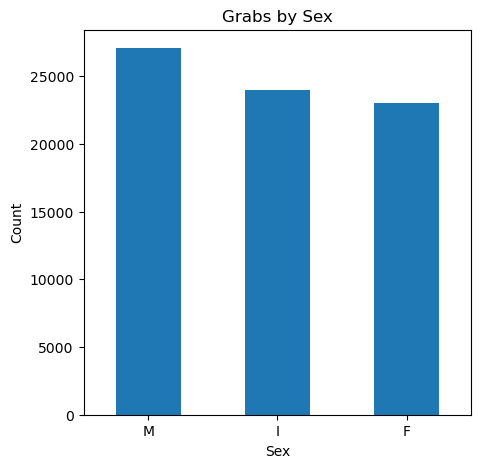

In [7]:
train_df["Sex"].value_counts().plot.bar(figsize=(5, 5))
plt.title("Grabs by Sex")
plt.xticks(rotation=0)
plt.xlabel("Sex")
plt.ylabel("Count");

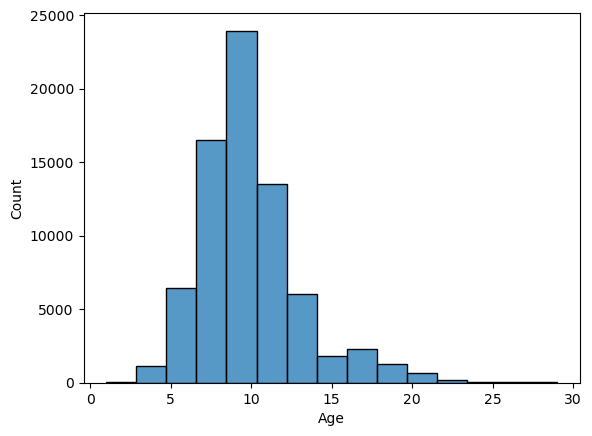

In [8]:
sns.histplot(train_df['Age'], bins=15, kde=False)
plt.show()

The histogram seems to have a right-tail skew. With most people crabs with age 10.

### Outlier Detection

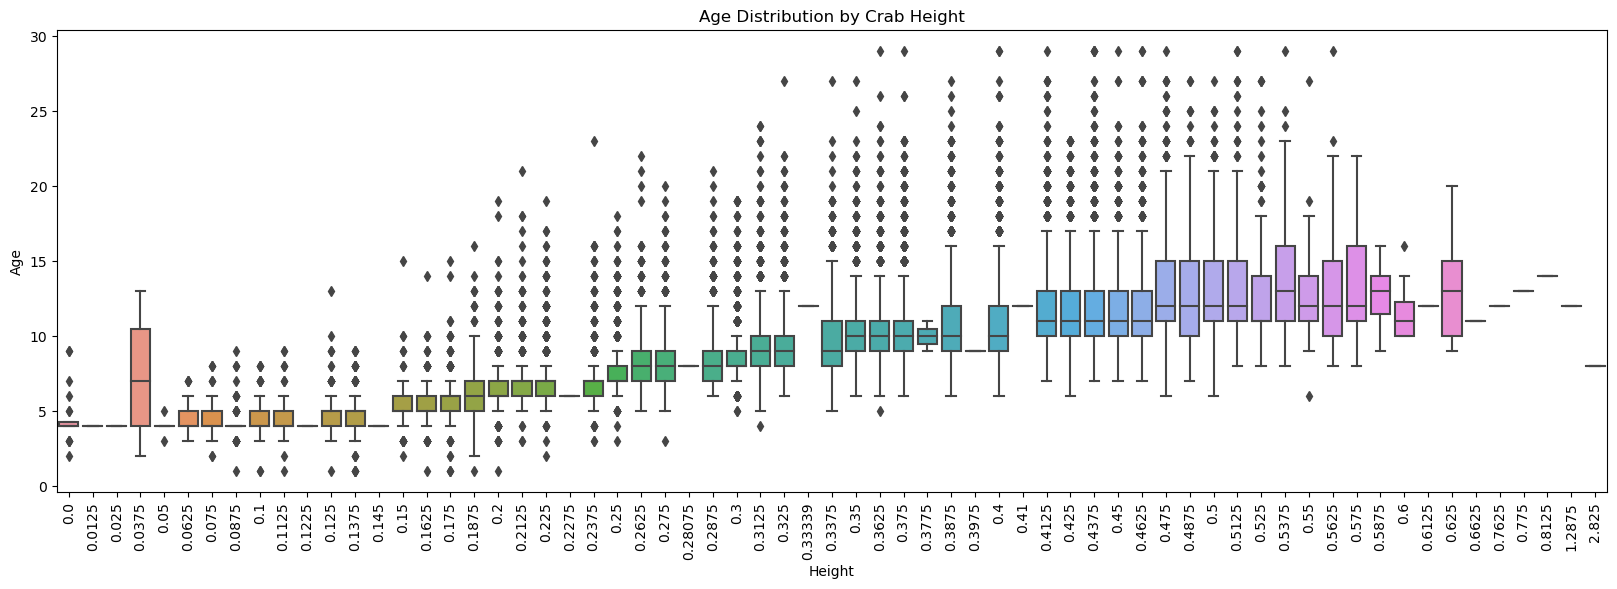

In [9]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=train_df, x='Height', y='Age')
plt.title("Age Distribution by Crab Height")
plt.xlabel("Height")
plt.ylabel("Age")
plt.xticks(rotation=90)
plt.show()

Based on the boxplot of the height disitrbution by age, there seems to be a lot of outliers for a lot of those crabs with different heights. Due to the large right-tail skew, it night be worth investigating what types of crabs these are (why they have a bigger age range than the average, despite being around the same height). 

## Clean Data

- Just for my personal preference, I'm going to lower case the column names. 

In [10]:
train_df.columns = train_df.columns.str.lower()
train_df.head()

,id,sex,length,diameter,height,weight,shucked weight,viscera weight,shell weight,age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [11]:
train_df.drop("id", axis=1, inplace=True)
train_df

,sex,length,diameter,height,weight,shucked weight,viscera weight,shell weight,age
0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8
...,...,...,...,...,...,...,...,...,...
74046,F,1.6625,1.2625,0.4375,50.660556,20.680960,10.361742,12.332033,10
74047,I,1.0750,0.8625,0.2750,10.446791,4.323299,2.296310,3.543687,6
74048,F,1.4875,1.2000,0.4125,29.483480,12.303683,7.540967,8.079607,10
74049,I,1.2125,0.9625,0.3125,16.768729,8.972617,2.919999,4.280774,8


## Preprocess

- Normalize the numerical vlaues
- OHE categorical values

In [12]:
categorical_features = ["sex"]
categorical_transformer = Pipeline(steps=[("ohe", OneHotEncoder(handle_unknown="ignore"))])

numerical_features = [
    "length",
    "diameter",
    "height",
    "weight",
    "shucked weight",
    "viscera weight",
    "shell weight"
]
numerical_transformer = Pipeline(steps=[("minmaxscaler", MinMaxScaler(feature_range=(0, 1)))])

preprocessor = ColumnTransformer(transformers=[
    ("categorical", categorical_transformer, categorical_features),
    ("numerical", numerical_transformer, numerical_features)
])

## Split train/val/test 

In [13]:
X = train_df.drop("age", axis=1)
y = train_df["age"]

NUM_IMAGES = 5000

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(59240, 14811, 59240, 14811)

## Build Model(s)

In [15]:
metrics = {}

In [34]:
def combine_model_metrics_to_main_df(metrics):
    main_df = pd.DataFrame.from_dict(metrics, orient="index", columns=["Score", "MAE", "MSE", "R_squared", "Fit_time"])
    return main_df

In [35]:
def add_train_metrics(model, model_name, X_test, y_test, fit_time, df):
    y_preds = model.predict(X_test)
    df[model_name] = [
        model.score(X_test, y_test),
        mean_absolute_error(y_test, y_preds),
        mean_squared_error(y_test, y_preds),
        r2_score(y_test, y_preds),
        fit_time
    ]
    return metrics

In [31]:
def show_cv_metrics(model):
    metrics = {
        "MAE": model["test_neg_mean_absolute_error"],
        "MSE": model["test_neg_mean_squared_error"],
        "R_squared": model["test_r2"],
        "Fit_time": model["fit_time"]
    }
    return metrics

In [32]:
def fit_and_eval(estimator, model_name, X_train, y_train, X_test, y_test, df):
    start = time.time()
    model = Pipeline(steps = [
        ("preprocessor", preprocessor),
        ("model", estimator)
    ])

    model.fit(X_train, y_train)
    end = time.time()
    training_time = end - start

    train_metrics = add_train_metrics(model, model_name, X_test, y_test, training_time, df)
    combined_metrics_df = combine_model_metrics_to_main_df(train_metrics)
    
    crossval_rf = cross_validate(model,
                                X_train,
                                y_train,
                                cv=3,
                                scoring=("neg_mean_squared_error","neg_mean_absolute_error", "r2"),
                                return_estimator=True)
    

    cv_metrics = show_cv_metrics(crossval_rf)
    return combined_metrics_df, cv_metrics

### Baseline Model Fits and Evaluations

In [20]:
rf_fit, rf_cv = fit_and_eval(RandomForestRegressor(), "RandomForestRegressor", X_train, y_train, X_test, y_test)

In [21]:
gb_fit, gb_cv = fit_and_eval(GradientBoostingRegressor(), "GradientBoostingRegressor", X_train, y_train, X_test, y_test)

In [22]:
lr_fit, lr_cv = fit_and_eval(linear_model.LinearRegression(), "LinearRegression", X_train, y_train, X_test, y_test)

In [23]:
ridge_fit, ridge_cv = fit_and_eval(linear_model.Ridge(), "RidgeRegression", X_train, y_train, X_test, y_test)

In [24]:
lasso_fit, lasso_cv = fit_and_eval(linear_model.Lasso(), "LassoRegression", X_train, y_train, X_test, y_test)

In [25]:
elastic_fit, elastic_cv = fit_and_eval(linear_model.ElasticNet(), "ElasticNetRegression", X_train, y_train, X_test, y_test)

### Evaluation

In [26]:
elastic_fit # should rename. This is really the df with all models metrics.

,Score,MAE,MSE,R_squared,Fit_time
RandomForestRegressor,0.569191,1.464457,4.390621,0.569191,33.674449
GradientBoostingRegressor,0.583947,1.426877,4.240231,0.583947,6.391024
LinearRegression,0.556912,1.488873,4.515764,0.556912,0.072999
RidgeRegression,0.556801,1.488311,4.516893,0.556801,0.045997
LassoRegression,-0.000014,2.344023,10.191707,-0.000014,0.036998
ElasticNetRegression,0.053137,2.277339,9.650022,0.053137,0.038999


<Axes: >

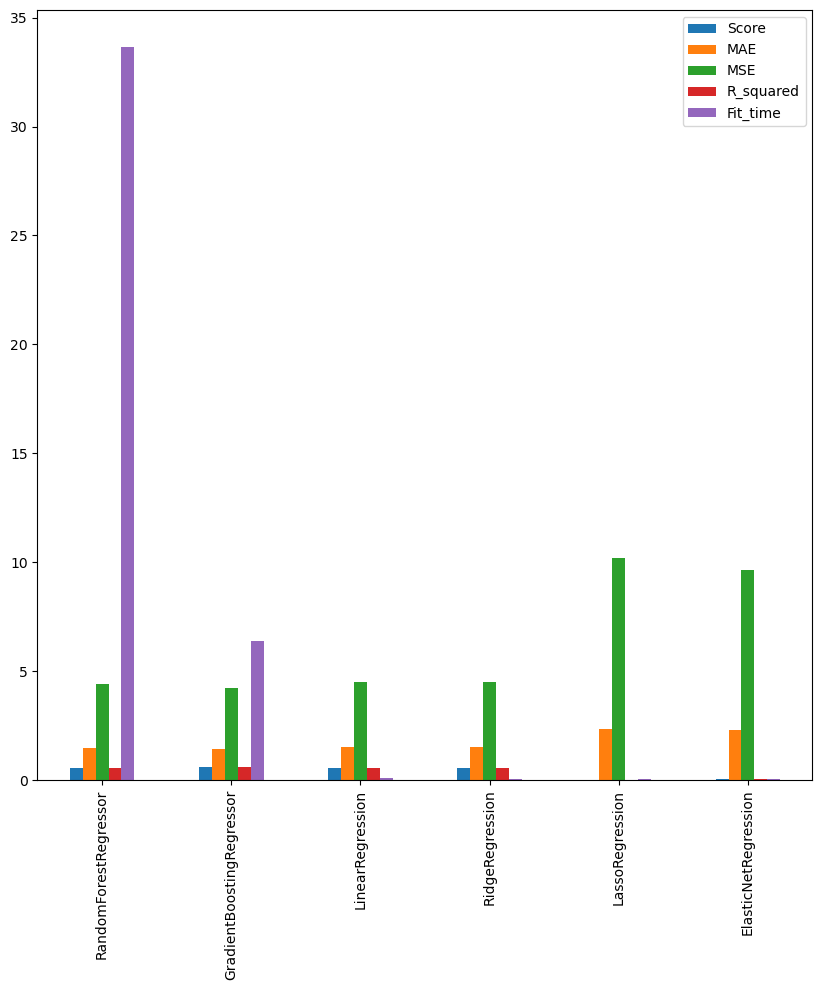

In [27]:
elastic_fit.plot.bar(figsize=(10, 10))

Based on the metrics table from above, we can see that the ensemble models `Random Forest Regressor` and `Gradient Boosting Regressor` both yield a smaller MAE, despite using the most time to fit the dataset. Therefore, I will try to tune the hyperparameters of those models first with RandomizedSearchCV and GridSearchCV to see if there is any improvement. 

### Hypertune Parameters

In [28]:
rf_params = {
    "model__n_estimators": np.arange(10, 100, 10),
    "model__max_depth": [None, 3, 5, 10],
    "model__min_samples_split": np.arange(2, 20, 2),
    "model__min_samples_leaf": np.arange(1, 20, 2),
    "model__max_features": [0.5, 1, "sqrt", "auto"],
    "model__max_samples": [1000]
}

gb_params = {
    "model__loss": ["squared_error", "absolute_error"],
    "model__learning_rate": np.arange(0.001, 0.1, 0.005),
    "model__n_estimators": np.arange(10, 100, 10),
    "model__subsample": np.arange(0, 1, 0.2),
    "model__criterion": ["friedman_mse", "squared_error"],
    "model__min_samples_split": np.arange(2, 20, 2),
    "model__min_samples_leaf": np.arange(1, 20, 2),
    "model__max_depth": [None, 3, 5, 10]
}

### RandomizedSearchCV

In [37]:
model_rf = Pipeline(steps = [
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor())
])


rf_random_search = RandomizedSearchCV(estimator=model_rf,
                                     param_distributions=rf_params,
                                     n_iter=10,
                                     cv=5,
                                     verbose=2)

model_gb = Pipeline(steps = [
    ("preprocessor", preprocessor),
    ("model", GradientBoostingRegressor())
])


gb_random_search = RandomizedSearchCV(estimator=model_gb,
                                     param_distributions =gb_params,
                                     n_iter=10,
                                     cv=5,
                                     verbose=2)

In [38]:
rf_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END model__max_depth=5, model__max_features=1, model__max_samples=1000, model__min_samples_leaf=1, model__min_samples_split=16, model__n_estimators=40; total time=   0.0s
[CV] END model__max_depth=5, model__max_features=1, model__max_samples=1000, model__min_samples_leaf=1, model__min_samples_split=16, model__n_estimators=40; total time=   0.0s
[CV] END model__max_depth=5, model__max_features=1, model__max_samples=1000, model__min_samples_leaf=1, model__min_samples_split=16, model__n_estimators=40; total time=   0.0s
[CV] END model__max_depth=5, model__max_features=1, model__max_samples=1000, model__min_samples_leaf=1, model__min_samples_split=16, model__n_estimators=40; total time=   0.0s
[CV] END model__max_depth=5, model__max_features=1, model__max_samples=1000, model__min_samples_leaf=1, model__min_samples_split=16, model__n_estimators=40; total time=   0.0s
[CV] END model__max_depth=None, model__max_features=0.5, mo

C:\Users\katie\anaconda3\envs\ml_basics\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END model__max_depth=10, model__max_features=auto, model__max_samples=1000, model__min_samples_leaf=1, model__min_samples_split=12, model__n_estimators=60; total time=   0.4s


C:\Users\katie\anaconda3\envs\ml_basics\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END model__max_depth=10, model__max_features=auto, model__max_samples=1000, model__min_samples_leaf=1, model__min_samples_split=12, model__n_estimators=60; total time=   0.4s


C:\Users\katie\anaconda3\envs\ml_basics\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END model__max_depth=10, model__max_features=auto, model__max_samples=1000, model__min_samples_leaf=1, model__min_samples_split=12, model__n_estimators=60; total time=   0.4s


C:\Users\katie\anaconda3\envs\ml_basics\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END model__max_depth=10, model__max_features=auto, model__max_samples=1000, model__min_samples_leaf=1, model__min_samples_split=12, model__n_estimators=60; total time=   0.4s


C:\Users\katie\anaconda3\envs\ml_basics\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END model__max_depth=10, model__max_features=auto, model__max_samples=1000, model__min_samples_leaf=1, model__min_samples_split=12, model__n_estimators=60; total time=   0.4s
[CV] END model__max_depth=3, model__max_features=1, model__max_samples=1000, model__min_samples_leaf=11, model__min_samples_split=14, model__n_estimators=10; total time=   0.0s
[CV] END model__max_depth=3, model__max_features=1, model__max_samples=1000, model__min_samples_leaf=11, model__min_samples_split=14, model__n_estimators=10; total time=   0.0s
[CV] END model__max_depth=3, model__max_features=1, model__max_samples=1000, model__min_samples_leaf=11, model__min_samples_split=14, model__n_estimators=10; total time=   0.0s
[CV] END model__max_depth=3, model__max_features=1, model__max_samples=1000, model__min_samples_leaf=11, model__min_samples_split=14, model__n_estimators=10; total time=   0.0s
[CV] END model__max_depth=3, model__max_features=1, model__max_samples=1000, model__min_samples_leaf=11, model__

C:\Users\katie\anaconda3\envs\ml_basics\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\katie\anaconda3\envs\ml_basics\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END model__max_depth=5, model__max_features=auto, model__max_samples=1000, model__min_samples_leaf=15, model__min_samples_split=4, model__n_estimators=30; total time=   0.1s
[CV] END model__max_depth=5, model__max_features=auto, model__max_samples=1000, model__min_samples_leaf=15, model__min_samples_split=4, model__n_estimators=30; total time=   0.1s


C:\Users\katie\anaconda3\envs\ml_basics\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\katie\anaconda3\envs\ml_basics\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END model__max_depth=5, model__max_features=auto, model__max_samples=1000, model__min_samples_leaf=15, model__min_samples_split=4, model__n_estimators=30; total time=   0.1s
[CV] END model__max_depth=5, model__max_features=auto, model__max_samples=1000, model__min_samples_leaf=15, model__min_samples_split=4, model__n_estimators=30; total time=   0.1s


C:\Users\katie\anaconda3\envs\ml_basics\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END model__max_depth=5, model__max_features=auto, model__max_samples=1000, model__min_samples_leaf=15, model__min_samples_split=4, model__n_estimators=30; total time=   0.1s
[CV] END model__max_depth=5, model__max_features=0.5, model__max_samples=1000, model__min_samples_leaf=9, model__min_samples_split=2, model__n_estimators=40; total time=   0.1s
[CV] END model__max_depth=5, model__max_features=0.5, model__max_samples=1000, model__min_samples_leaf=9, model__min_samples_split=2, model__n_estimators=40; total time=   0.1s
[CV] END model__max_depth=5, model__max_features=0.5, model__max_samples=1000, model__min_samples_leaf=9, model__min_samples_split=2, model__n_estimators=40; total time=   0.1s
[CV] END model__max_depth=5, model__max_features=0.5, model__max_samples=1000, model__min_samples_leaf=9, model__min_samples_split=2, model__n_estimators=40; total time=   0.1s
[CV] END model__max_depth=5, model__max_features=0.5, model__max_samples=1000, model__min_samples_leaf=9, model__

C:\Users\katie\anaconda3\envs\ml_basics\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('categorical',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['sex']),
                                                                              ('numerical',
                                                                               Pipeline(steps=[('minmaxscaler',
                                                                                                MinMaxScaler())]),
                                                                               ['length',
                                                                                'diameter',
                                                                                'height',
                                                                                'weight',
                                                                                'shucked '
                                                                                'weight',
                                                                                'viscera '
                                                                                'weight',
                                                                                'shell '
                                                                                'weight'])])),
                                             ('model',
                                              RandomForestRegressor())]),
                   param_distributions={'model__max_depth': [None, 3, 5, 10],
                                        'model__max_features': [0.5, 1, 'sqrt',
                                                                'auto'],
                                        'model__max_samples': [1000],
                                        'model__min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'model__min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'model__n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=2)

In [39]:
rf_random_search.best_params_

{'model__n_estimators': 60,
 'model__min_samples_split': 12,
 'model__min_samples_leaf': 1,
 'model__max_samples': 1000,
 'model__max_features': 'auto',
 'model__max_depth': 10}

In [42]:
cv_y_preds = rf_random_search.predict(X_test)
scores = {
    "Score": rf_random_search.score(X_train, y_train),
    "MAE": mean_absolute_error(y_test, cv_y_preds),
    "MSE": mean_squared_error(y_test, cv_y_preds),
    "R_squared": r2_score(y_test, cv_y_preds)
}
scores

{'Score': 0.5806752522034613,
 'MAE': 1.432217745830656,
 'MSE': 4.281577209483328,
 'R_squared': 0.5798901910604302}

The Score (baseline) was 0.56. After tuning, it was 0.58.
The MAE (baseline) was 1.46. After tuning, it was 1.43.

In [43]:
gb_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END model__criterion=squared_error, model__learning_rate=0.031, model__loss=squared_error, model__max_depth=5, model__min_samples_leaf=19, model__min_samples_split=2, model__n_estimators=50, model__subsample=0.4; total time=   1.9s
[CV] END model__criterion=squared_error, model__learning_rate=0.031, model__loss=squared_error, model__max_depth=5, model__min_samples_leaf=19, model__min_samples_split=2, model__n_estimators=50, model__subsample=0.4; total time=   1.9s
[CV] END model__criterion=squared_error, model__learning_rate=0.031, model__loss=squared_error, model__max_depth=5, model__min_samples_leaf=19, model__min_samples_split=2, model__n_estimators=50, model__subsample=0.4; total time=   1.9s
[CV] END model__criterion=squared_error, model__learning_rate=0.031, model__loss=squared_error, model__max_depth=5, model__min_samples_leaf=19, model__min_samples_split=2, model__n_estimators=50, model__subsample=0.4; total time

[CV] END model__criterion=squared_error, model__learning_rate=0.046, model__loss=squared_error, model__max_depth=None, model__min_samples_leaf=17, model__min_samples_split=2, model__n_estimators=90, model__subsample=0.8; total time=  23.4s
[CV] END model__criterion=friedman_mse, model__learning_rate=0.041, model__loss=squared_error, model__max_depth=3, model__min_samples_leaf=17, model__min_samples_split=2, model__n_estimators=50, model__subsample=0.0; total time=   0.0s
[CV] END model__criterion=friedman_mse, model__learning_rate=0.041, model__loss=squared_error, model__max_depth=3, model__min_samples_leaf=17, model__min_samples_split=2, model__n_estimators=50, model__subsample=0.0; total time=   0.0s
[CV] END model__criterion=friedman_mse, model__learning_rate=0.041, model__loss=squared_error, model__max_depth=3, model__min_samples_leaf=17, model__min_samples_split=2, model__n_estimators=50, model__subsample=0.0; total time=   0.0s
[CV] END model__criterion=friedman_mse, model__learn

C:\Users\katie\anaconda3\envs\ml_basics\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\katie\anaconda3\envs\ml_basics\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\katie\anaconda3\envs\ml_basics\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\katie\anaconda3\envs\ml_basics\lib\site-packages\sklearn\ensemble\_gb.py", line 420, in fit
    sel

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('categorical',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['sex']),
                                                                              ('numerical',
                                                                               Pipeline(steps=[('minmaxscaler',
                                                                                                MinMaxScaler())]),
                                                                               ['length',
                                                                                'diameter',
                                                                                'height',
                                                                                'weight',
                                                                                'shucked '
                                                                                'weight',
                                                                                'viscera '
                                                                                'weight',
                                                                                'shell '
                                                                                'weight'])])),
                                             ('mo...
       0.046, 0.051, 0.056, 0.061, 0.066, 0.071, 0.076, 0.081, 0.086,
       0.091, 0.096]),
                                        'model__loss': ['squared_error',
                                                        'absolute_error'],
                                        'model__max_depth': [None, 3, 5, 10],
                                        'model__min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'model__min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'model__n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90]),
                                        'model__subsample': array([0. , 0.2, 0.4, 0.6, 0.8])},
                   verbose=2)

In [44]:
gb_random_search.best_params_

{'model__subsample': 0.8,
 'model__n_estimators': 90,
 'model__min_samples_split': 2,
 'model__min_samples_leaf': 17,
 'model__max_depth': None,
 'model__loss': 'squared_error',
 'model__learning_rate': 0.046,
 'model__criterion': 'squared_error'}

In [46]:
cv_y_preds = gb_random_search.predict(X_test)
scores = {
    "Score": gb_random_search.score(X_train, y_train),
    "MAE": mean_absolute_error(y_test, cv_y_preds),
    "MSE": mean_squared_error(y_test, cv_y_preds),
    "R_squared": r2_score(y_test, cv_y_preds)
}
scores

{'Score': 0.8325039150518421,
 'MAE': 1.4461610484553569,
 'MSE': 4.3447854847365175,
 'R_squared': 0.573688173640027}

### Add Original Dataset 

In [50]:
real_df = pd.read_csv("data/crab_age_raw/CrabAgePrediction.csv")
real_df

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,F,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,9
1,M,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6
2,I,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,6
3,F,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,10
4,I,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,6
...,...,...,...,...,...,...,...,...,...
3888,F,1.4625,1.1375,0.3250,24.819987,11.651644,5.854172,6.378637,8
3889,F,1.5500,1.2125,0.4375,34.458817,15.450477,7.172423,9.780577,10
3890,I,0.6250,0.4625,0.1625,2.012815,0.765436,0.524466,0.637864,5
3891,I,1.0625,0.7750,0.2625,10.347568,4.507570,2.338834,2.976698,6


In [48]:
real_artificial_df= pd.concat([])

TypeError: only size-1 arrays can be converted to Python scalars

This is evolving into building a discriminator model. Maybe you can test how to generate artificial crab data that can adopt the natural physical qualities of the real dataset.